### General advice (delete this cell before submitting for review)

> * When choosing a location for your analysis, **select an area that has data on both the NCI and DEA Sandbox** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products).
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
> * When adding **Products used**, embed the hyperlink to that specific product on the DEA Explorer using the `[product_name](product url)` syntax.
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * Use Australian English in markdown cells and code comments.
> * Check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DEA docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in heirachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
> * For additional guidance, refer to the style conventions and layouts in approved `develop` branch notebooks. 
Examples include
    * [Frequently_used_code/Using_load_ard.ipynb](./Frequently_used_code/Using_load_ard.ipynb)
    * [Real_world_examples/Coastal_erosion.ipynb](./Real_world_examples/Coastal_erosion.ipynb)
    * [Scripts/dea_datahandling.py](./Scripts/dea_datahandling.py)
> * The DEA Image placed in the title cell will display as long as the notebook is contained in one of the standard directories.
It does not work in the highest level directory (hence why it doesn't display in the original template notebook).
> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


# Descriptive title that follows notebook filename <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [60]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import seaborn as sns

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_classificationtools import get_training_data_for_shp, predict_xr

In [2]:
import os
import pickle
import numpy
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [3]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters

Explain parameters in markdown 

# Edit shapefile values to match 0-x

In [20]:
# The path to the input shapefile
path = '../Supplementary_data/Machine_learning_with_ODC/Cell_-16_-39_2015.shp'
# The year you wish to extract data for, typically the same year the labels were created
year = 2015
# The product you wish to extract
product = 'ls8_nbart_geomedian_annual'
# This is an option to calculate the mean of the values within the feature, it is useful for reducing noise and simplifying your training data
feature_stats = 'mean'
# This is the name of column in your attribute table that contains the class labels
field = 'classnum'

## Extract training data using a shapefile

This function takes a shapefile that contains class labels and extracts the data within these areas

> **Note:** The class labels will be contained in the first column of the output array

In [22]:
# Empty list which we will populate with data

out = []

# Calling the extraction function

column_names = get_training_data_for_shp(path, out,
                                         product=product,
                                         time=('{}-01-01'.format(year),
                                               '{}-12-31'.format(year)),
                                         crs='EPSG:3577', field=field,
                                         calc_indices=None,
                                         feature_stats=feature_stats)

# Stacking the extracted training data for each feature into a single array

model_input = np.vstack(out)

print(model_input.shape)


Loading data...
Rasterizing features and extracting data...


Explain the array and print it!

## Preprocessing

In [24]:
# Remove any potential nans
model_input = model_input[~numpy.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (217, 7)


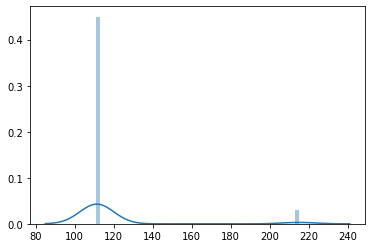

In [45]:
sns.distplot(model_input[:,0])

In [25]:
# Split into training and testing data, 80 % is used for training with 20 % held back for testing.
# Use class to provide similar distribution across classes under the 'stratify' parameter
# in training and testing data

model_train, model_test = model_selection.train_test_split(model_input, stratify=model_input[:, 0],
                                                           train_size=0.8, random_state=0)

print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)


Train shape: (173, 7)
Test shape: (44, 7)


## Model preparation

In [30]:
model_variables = column_names[1:]

column_names_indices = {}

for col_num, var_name in enumerate(column_names):
    column_names_indices[var_name] = col_num

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])


In [50]:
# Initialise model
model = tree.DecisionTreeClassifier()

## Train model

In [51]:
# Train model
model.fit(model_train[:,model_col_indices], model_train[:,0])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Analyse results

In [52]:
# This shows the feature importance of the input features for predicting the class labels provided
print(dict(zip(model_variables, model.feature_importances_)))

{'blue': 0.16577657531051207, 'green': 0.7826180444964085, 'red': 0.016419893697798022, 'nir': 0.01876559279748347, 'swir1': 0.0, 'swir2': 0.016419893697798022}


# Simplify names of classes

In [53]:
class_names = {111: 'Cultivated Terrestrial Vegetated', 112: 'Natural Terrestrial Vegetated', 
 123: 'Cultivated Aquatic Vegetated', 124: 'Natural Aquatic Vegetated', 
 215:'Artificial Surface', 216:'Natural Surface', 227:'Artificial Water', 228:'Natural Water'}

## accuracy

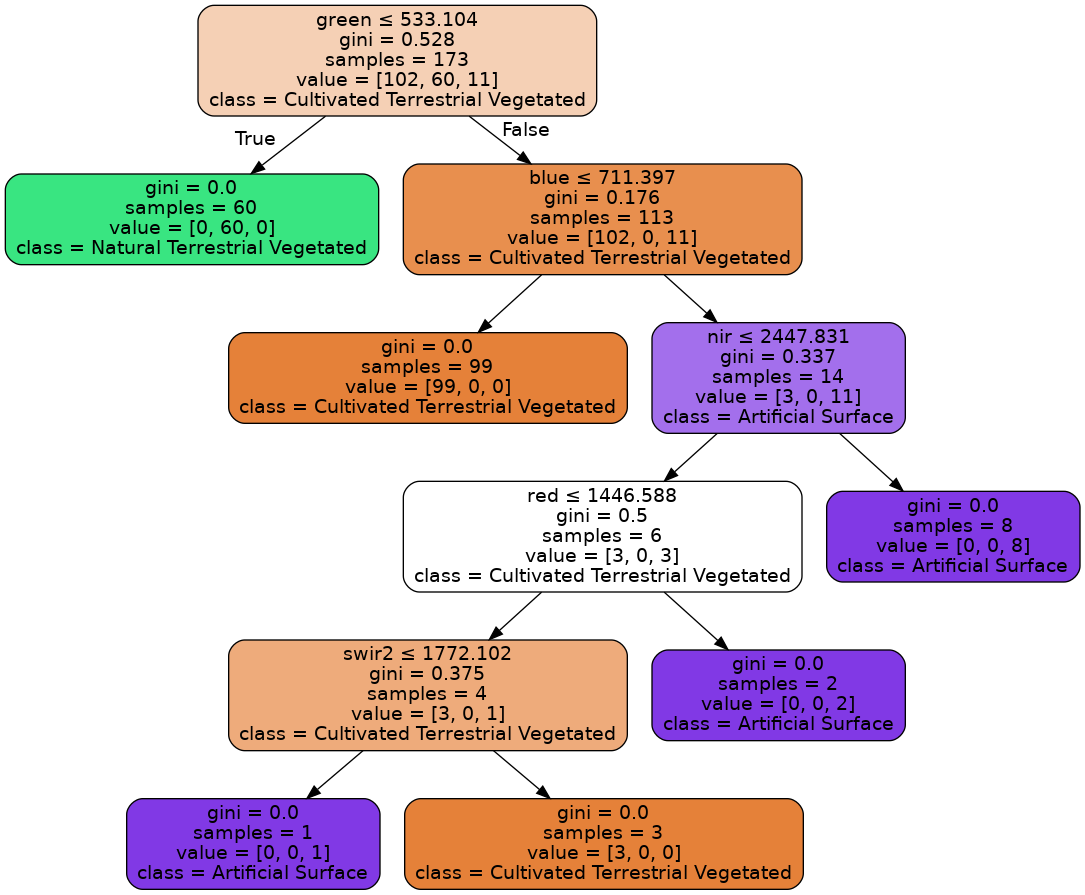

In [54]:
# Plot decision tree

class_codes = numpy.unique(model_train[:,0])

class_names_in_model = list({k: class_names[k] for k in class_codes}.values())

dot_data = StringIO()

tree.export_graphviz(model, out_file=dot_data, feature_names = model_variables, class_names=class_names_in_model,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Prediction

In [55]:
query = {'time': ('{}-01-01'.format(year), '{}-12-31'.format(year))}
query['x'] = (-1559125, -1500000)
query['y'] = (-3851325, -3800000)
query['crs'] = 'EPSG:3577'
query['resolution'] = (-25, 25)

In [65]:
geomedian_data = dc.load(product='ls8_nbart_geomedian_annual', group_by='solar_day', **query)

In [66]:
predicted = predict_xr(model, geomedian_data, progress=True)

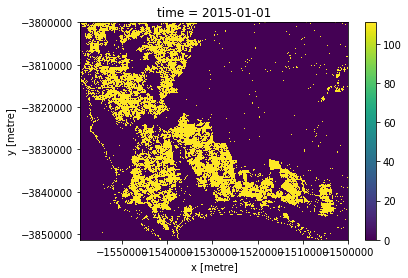

In [76]:
xr.where(predicted==111, predicted, 0).plot()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)